In [11]:
%matplotlib inline
import xmitgcm
import xgcm
import xarray as xr
import matplotlib.pyplot as plt
from xlayers.core import layers_apply
import numpy as np
from MITgcmutils import jmd95
import time as time
import matplotlib.colors as colors
from pathlib import Path
import pandas as pd
from scipy.interpolate import interp1d

In [12]:
dsctr = xr.open_dataset("../data/single_basin_ctrl.nc", engine = "netcdf4")
dsctr["Volume"] = dsctr.rA * dsctr.drF * dsctr.hFacC

dsGM2x = xr.open_dataset("../data/single_basin_GM2X.nc", engine = "netcdf4")
dsGM2x["Volume"] = dsGM2x.rA * dsGM2x.drF * dsGM2x.hFacC

dsRedi2x = xr.open_dataset("../data/single_basin_Redi2X.nc", engine = "netcdf4")
dsRedi2x["Volume"] = dsRedi2x.rA * dsRedi2x.drF * dsRedi2x.hFacC

dskappa2x = xr.open_dataset("../data/single_basin_Kappa2X.nc", engine = "netcdf4")
dskappa2x["Volume"] = dskappa2x.rA * dskappa2x.drF * dskappa2x.hFacC

In [13]:
def initialize_grid(ds):
    """
    Initialize the xgcm grid with given metrics.
    
    Parameters:
    ds (xarray.Dataset): The dataset to initialize the grid from.
    
    Returns:
    xgcm.Grid: Initialized grid.
    """
    metrics = {
        ('X',): ['dxC', 'dxG'],
        ('Y',): ['dyC', 'dyG'],
        ('Z',): ['drF', 'drC'],
        ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw']
    }
    return xgcm.Grid(ds, periodic=['X'], metrics=metrics)

class myRun: 
    '''
    packed class for a MITgcm simulation: saving some intermidiate variables,
    and implementing some functions for calculation and plotting.
    The goal is to reduce unnecessary repeat of code for analyzing different simulations
    '''
    def __init__(self,dataset:xr.Dataset,Kgm=500,Kredi=500,nxkappa=1):
        
        self.ds=dataset
        ## init grid
#         metrics = {
#             ('X',): ['dxC', 'dxG'], # X distances
#             ('Y',): ['dyC', 'dyG'], # Y distances
#             ('Z',): ['drF', 'drC'], # Z distances
#             ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
#         }
#         self.grid=xgcm.Grid(self.ds, periodic=['X'], metrics=metrics)
        self.grid = initialize_grid(self.ds)
        self.rhoinit()
        self.kappainit(nxkappa=nxkappa)
        ## init GM parameters Kuz,Kvy,Kwx,Kwy
        self.calc_GM_parameters(Kgm=Kgm,Kredi=Kredi)  
        self.calc_GM_vels()
        ################################################
        #Volume advective transport (Eulerian+gm)
        xA=self.ds.dyG*self.ds.drF
        yA=self.ds.dxG*self.ds.drF
        self.fVolEux=self.ds.uVeltave.mean('time')*xA
        self.fVolEuy=self.ds.vVeltave.mean('time')*yA
        self.fVolEur=self.ds.wVeltave.mean('time')*self.ds.rA
        self.fVolgmx=self.ugmFromTensor.fillna(0)*xA.fillna(0)
        self.fVolgmy=self.vgmFromTensor.fillna(0)*yA.fillna(0)
        self.fVolgmr=self.wgmFromTensor.fillna(0)*self.ds.rA.fillna(0)
        
        self.fVolx=self.fVolEux+self.fVolgmx
        self.fVoly=self.fVolEuy+self.fVolgmy
        self.fVolr=self.fVolEur+self.fVolgmr
        ################################################
        self.calcOptlayer()
        self.rho_binning(self.layers1_bounds)
        self.init_rho_for_layer()
        self.calc_layer_depth()
        
    
        
    def kappainit(self,nxkappa=1):
        '''
        Initialize BL diapycnal diffusivity kappa (kdia3d)
        nxkappa: kappa times n (for 2xkappa run)
        '''
        #BryanLewis kappa profile
        diffKrBL79surf=2e-5;
        diffKrBL79deep= 1e-4;
        diffKrBL79Ho  = -2000;
        diffKrBL79scl = 150;
        #A hack to broadcast Zl to 3D
        Z3d=0*self.ds.rA+self.ds.Zl
        kdia3d=diffKrBL79surf+(diffKrBL79deep-diffKrBL79surf)*(np.arctan(-(Z3d-diffKrBL79Ho)/diffKrBL79scl)/np.pi+0.5 );
        kdia3d=kdia3d.transpose('Zl','YC','XC')
        self.kdia3d=nxkappa*kdia3d
        self.nxkappa=nxkappa

    def rhoinit(self,rhoConst=1035,use_pd=True,refPres=2000):
        '''
        calculate the density surfaces
        use_pd: calculate potential density rather than locally referred
        refPres: reference pressure for potential density in dbar
        '''

        Stave=self.ds.Stave.mean('time')
        Ttave=self.ds.Ttave.mean('time')

        Stave=Stave.where(Stave!=0)
        if use_pd:
            rho3D=jmd95.densjmd95(Stave,Ttave,refPres)    
        else:
            locPres3D=self.ds.locPres.broadcast_like(Stave)
            locPres=self.ds.PHrefC*rhoConst
            rho3D=jmd95.densjmd95(Stave,Ttave,locPres3D/10000)
        self.rho3D=0*Stave+rho3D
    
    
    
    def rho_binning(self,layers1_bounds):
        '''
        Binning rho3D into density bins decided by layers1_bounds
        add self.rhoindex
        '''
        #is it reasonable to put layers1_bounds into the class? Jan8,2023
        self.layers1_bounds=layers1_bounds
        #def rhoidinit(self):
        '''
        calculate rhoindex based on rho3D data and layers1_bounds
        There used to be a helper function but is removed now
        '''
        self.Nlayersbin=len(self.layers1_bounds)
        rhoindex=0*self.rho3D.load().data
        rho3Ddata=self.rho3D.load().data
        [Nz,Ny,Nx]=rhoindex.shape

        #layers1_bounds: boundary of layers, index 1:N (or 0:N-1 in python)
        #rhoindex:index for rho at the center of layers1_bounds index 1:N-1 (or 0:N-2 in python)

        for idx in range(Nx):
            for idy in range(Ny):     
                for idz in range(Nz):
                    rhotemp=rho3Ddata[idz,idy,idx]-1000
                    #print(rhotemp.load())
                    if np.isnan(rhotemp):
                        rhoindex[idz,idy,idx]=np.nan
                        continue
                    #rhoid_currentgrid=0
                    for idrho in range(1,self.Nlayersbin):
                        rhoid_currentgrid=idrho-1 # grid idrho-1 between boundary [idrho-1, idrho]

                        if rhotemp<layers1_bounds[idrho]:
                            break
                    #print(rhoid_currentgrid)
                    rhoindex[idz,idy,idx]=rhoid_currentgrid
        self.rhoindex=rhoindex
        [nz,ny,nx]=rhoindex.shape
        self.rhoindext=rhoindex[np.r_[0,0:nz-1],:,:]
        self.rhoindexs=rhoindex[:,np.r_[0,0:ny-1],:]
        self.rhoindexn=rhoindex[:,np.r_[1:ny,ny-1],:]
        self.rhoindexw=rhoindex[:,:,np.r_[nx-1,0:nx-1]]
        self.rhoindexe=rhoindex[:,:,np.r_[1:nx,0]]

    
    
    '''    
    def plotsst(self):
        #implemented
        pass
    def plotEmP(self):
        #not implemented
        pass
    def rhoinit(self,layers1_bounds=layers1_bounds,rhoConst=1035,use_pd=True,refPres=2000):
        pass
    ''' 
    def calc_GM_parameters(self,Kgm=500,Kredi=500,modifiedGMTensor=True):
        '''
        calculating 4 GM parameters (Kuz,Kvy,Kwx,Kwy) from model diagnostics (separating Redi term)
        '''       
        #modifiedGMTensor=True
        if modifiedGMTensor is True:
            #Kgm=1000
            #Kredi=500
            print("Kgm:",Kgm,"Kredi",Kredi)
            self.GM_Kuz_gm=-self.ds.GM_Kuz.mean('time')*Kgm
            self.GM_Kvy_gm=-self.ds.GM_Kvy.mean('time')*Kgm
            self.GM_Kwx_gm=self.ds.GM_Kwx.mean('time')*Kgm
            self.GM_Kwy_gm=self.ds.GM_Kwy.mean('time')*Kgm

        else:
            raise ValueError("Not implemented")
            Kgm=1000
            Kredi=500
            GM_Kuz_gm=self.ds.GM_Kuz.mean('time')*Kgm/(Kgm-Kredi)
            GM_Kvy_gm=self.ds.GM_Kvy.mean('time')*Kgm/(Kgm-Kredi)
            GM_Kwx_gm=self.ds.GM_Kwx.mean('time')*Kgm/(Kgm+Kredi)
            GM_Kwy_gm=self.ds.GM_Kwy.mean('time')*Kgm/(Kgm+Kredi)
    #########################################################################
    #This block is calculating GM velocities
    def calc_GM_vels(self):
        '''
        calculating GM velocities
        '''
        #This
        maskGMPsiX=self.grid.interp(self.grid.interp(self.ds.maskC.where(self.ds.maskC),'Z', boundary = "fill", fill_value = np.nan),'X')
        maskGMPsiX[0,:,:]=np.nan #mask top layer
        maskGMPsiX=maskGMPsiX.fillna(0)
        maskGMPsiY=self.grid.interp(self.grid.interp(self.ds.maskC.where(self.ds.maskC),'Z', boundary = "fill", fill_value = np.nan),'Y', boundary = "fill", fill_value = np.nan)
        maskGMPsiY[0,:,:]=np.nan #mask top layer
        maskGMPsiY=maskGMPsiY.fillna(0)
        maskr=self.grid.interp(self.ds.maskC.astype('double'),'Z', boundary = "fill", fill_value = np.nan)
        maskr=maskr.where(maskr>0.5)
        maskr=maskr.fillna(0)
        PsixGM_Tensor=self.grid.interp(self.GM_Kwx_gm*self.ds.rA,'X', boundary = "fill", fill_value = np.nan)/self.ds.rAw
        PsixGM_Tensor=PsixGM_Tensor.where(maskGMPsiX)
        PsixGM_Tensor=PsixGM_Tensor.fillna(0)
        delPsixGM_Tensor=self.grid.diff(PsixGM_Tensor,'Z',boundary='fill')
        ugmFromTensor=delPsixGM_Tensor/self.ds.drF*self.ds.hFacW
        PsiyGM_Tensor=self.grid.interp(self.GM_Kwy_gm*self.ds.rA,'Y', boundary = "fill", fill_value = np.nan)/self.ds.rAs
        PsiyGM_Tensor=PsiyGM_Tensor.where(maskGMPsiY)
        PsiyGM_Tensor=PsiyGM_Tensor.fillna(0)
        delPsiyGM_Tensor=self.grid.diff(PsiyGM_Tensor,'Z',boundary='fill')
        vgmFromTensor=delPsiyGM_Tensor/self.ds.drF*self.ds.hFacS
        wgmFromTensor=self.grid.diff(PsixGM_Tensor*self.ds.dyG,'X',boundary='periodic')+self.grid.diff(PsiyGM_Tensor*self.ds.dxG,'Y', boundary = "fill", fill_value = np.nan)
        wgmFromTensor=wgmFromTensor/self.ds.rA
        wgmFromTensor=wgmFromTensor.fillna(0)
        wgmFromTensor=maskr*wgmFromTensor
        self.ugmFromTensor=ugmFromTensor
        self.vgmFromTensor=vgmFromTensor
        self.wgmFromTensor=wgmFromTensor
        
    def init_rho_for_layer(self):
        # interpolating rho to u/v grids
        rhoatV=self.grid.interp(self.rho3D,'Y', boundary = "fill", fill_value = np.nan)
        rhoatU=self.grid.interp(self.rho3D,'X', boundary = "fill", fill_value = np.nan)
        rhoatU=rhoatU.fillna(0)
        rhoatV=rhoatV.fillna(0)


        #Volume flux in x/y direction
        #tmpfVoly=self.fVolEuy+self.fVolgmy
        #tmpfVolx=self.fVolEux+self.fVolgmx
        
        #nonan here means???
        ##############################################
        #This block below interpolates the data below the bottom of the ocean,
        #to avoid strange behavior of density interpolation
        ##############################################
        rhoatV_nonan=rhoatV.copy().load().data
        rhoatU_nonan=rhoatU.copy().load().data
        rho_nonan=self.rho3D.copy().load().data
        
        
        [nz,ny,nx]=rhoatV_nonan.shape
        for i in range(nx):
            for j in range(ny):
                rhotempV=0
                rhotempU=0
                rhotemp0=0
                for k in range(nz):
                    if(np.isnan(rhoatV_nonan[k,j,i])):
                        rhoatV_nonan[k,j,i]=rhotempV
                    else:
                        rhotempV=rhoatV_nonan[k,j,i]
                    if(np.isnan(rhoatU_nonan[k,j,i])):
                        rhoatU_nonan[k,j,i]=rhotempU
                    else:
                        rhotempU=rhoatU_nonan[k,j,i]
                    if(np.isnan(rho_nonan[k,j,i])):
                        rho_nonan[k,j,i]=rhotemp0
                    else:
                        rhotemp0=rho_nonan[k,j,i]
        ###############################################                
        #turn numpy variables into xarray variables
        rhoatV_nonan=rhoatV.fillna(0)*0+rhoatV_nonan
        rhoatU_nonan=rhoatU.fillna(0)*0+rhoatU_nonan
        rho_nonan=self.rho3D.fillna(0)*0+rho_nonan
        
        self.rho_nonan=rho_nonan
        self.rhoatV_nonan=rhoatV_nonan
        self.rhoatU_nonan=rhoatU_nonan
        
    def calc_layer_depth(self):
        '''
        calc_streamfunction
        '''
        def layer_depth_interp_mat(sLayer_mat,sZ_mat,Z):
            '''
            Calculating the mean depth of density layer sigma
            sLayer_mat: an array of sLayer
            sZ_mat: an array of sZ
            Z: depth Z
            '''
            def layer_depth_interp_1d(sLayer,sZ,Z):
                '''
                Calculating the mean depth of density layer sigma
                sLayer: area below (density) Layer sigma
                sZ: area below depth Z
                Z: depth Z
                '''
                fnew=interp1d(sZ,Z,fill_value="extrapolate")
                ZLayer=fnew(sLayer)
                return ZLayer

            [Ny,Nlayer]=sLayer_mat.shape
            Zlayer_mat=np.zeros([Ny,Nlayer])
            for iy in range(Ny):
                #print("iy:",iy)
                Zlayer_mat[iy,:]=layer_depth_interp_1d(sLayer_mat[iy,:],sZ_mat[iy,:],Z,)
            Zlayer_mat[Zlayer_mat>0]=0
            Zlayer_mat[Zlayer_mat<-4000]=-4000
            return Zlayer_mat
        
        
        
        ###############################################
        ##if the resolution is not high enough, the streamfunction will not be smooth 
        ##perhaps using a non-linear scale would be better, though
        
        layers1_bounds_streamfunc=self.ds.layer_1RHO_bounds.load().data#np.linspace(29,37.5,1000)
        dz_layers_atV= layers_apply(self.ds.hFacS,(self.rhoatV_nonan-1000), np.array(layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')

        dz_layers_atV_zonalsum=dz_layers_atV.sum('XC')
        z_layers_atV_zonalsum=dz_layers_atV_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
        z_area_below=self.ds.drF.where(self.ds.hFacS==1).sum('XC').transpose('YG','Z')
        z_area_below=z_area_below[:,::-1].cumsum('Z')[:,::-1]
        [Ny,Nz]=z_area_below.shape
        z_area_below_np=np.zeros([Ny,Nz+1])
        z_area_below_np[:,:-1]=z_area_below
        layer_depth=layer_depth_interp_mat(z_layers_atV_zonalsum.load().data,z_area_below_np,self.ds.Zp1)
        self.layer_depth=layer_depth
        self.layers1_bounds_streamfunc=layers1_bounds_streamfunc
        
        
        
    def draw_streamfunc_depth(self):
        '''
        draw_streamfunction
        '''
        dPsiY_layers= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        dPsiX_layers= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        dPsiY_layers_zonalsum=(dPsiY_layers).sum('XC') 
        PsiY_layers_zonalsum=-dPsiY_layers_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
        self.PsiY_layers_zonalsum=PsiY_layers_zonalsum


        #plt.contourf(0*PsiY_layers_zonalsum.T+dsGM2x.YG,layer_depth.T,PsiY_layers_zonalsum.T/1e6,levels=np.linspace(-10,10,20),vmin=-10,vmax=10,cmap='seismic')
        XX=(0*self.PsiY_layers_zonalsum.T+self.ds.YG).load().data
        YY=self.layer_depth.T
        ZZ=(self.PsiY_layers_zonalsum.T.rolling(YG=5).mean()/1e6).load().data
        ZZ[np.isnan(YY)]=np.nan
        YY[np.isnan(YY)]=0

        #print(XX)
        #print(YY)
        print(ZZ)
        im=plt.contourf(XX.T,YY.T,ZZ.T,levels=np.linspace(-13.5,13.5,28),vmin=-13.5,vmax=13.5,cmap='seismic',extend='both')
        
    def compute_streamfunction(self):
        '''
        draw_streamfunction
        '''
        dPsiY_layers= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        dPsiX_layers= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        dPsiY_layers_zonalsum=(dPsiY_layers).sum('XC') 
        PsiY_layers_zonalsum=-dPsiY_layers_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
        self.PsiY_layers_zonalsum=PsiY_layers_zonalsum

        #plt.contourf(0*PsiY_layers_zonalsum.T+dsGM2x.YG,layer_depth.T,PsiY_layers_zonalsum.T/1e6,levels=np.linspace(-10,10,20),vmin=-10,vmax=10,cmap='seismic')
        XX=(0*self.PsiY_layers_zonalsum.T+self.ds.YG).load().data
        YY=self.layer_depth.T
        ZZ=(self.PsiY_layers_zonalsum.T.rolling(YG=5).mean()/1e6).load().data
        ZZ[np.isnan(YY)]=np.nan
        YY[np.isnan(YY)]=0

        self.Psi = ZZ
        self.Psi_xcoord = XX
        self.Psi_ycoord = YY

    ###########################################################################
    def calcOptlayer(self,Nnewlayer=16,rhoref=1000):
        'Calculate optimal layer bounds'
        layers1_bounds=[28,29,30,31,32,33,34,
             35.15,
             36.52,
             37.02,
             37.18,
             37.23,
             37.24,
             37.25,
             37.262,
             37.271,
             37.279,
             37.286,
             37.294,
             37.302,
             37.310,
             37.318,
             37.324,
             37.330,
             37.34,
             37.35,37.36,37.37]
        def rhoInt(Xdata,rhoindex,Nlayersbin):
            ''''''
            'Integrate Xdata at density layers'
            ''''''
            dX_rho=np.zeros([Nlayersbin,1])
            [Nz,Ny,Nx]=rhoindex.shape
            for idx in range(Nx):
                for idy in range(Ny):
                    for idz in range(Nz): 
                        rhoindextemp=rhoindex[idz,idy,idx]
                        if(~np.isnan(rhoindextemp)):  
                            dX_rho[int(rhoindextemp)]+=Xdata[idz,idy,idx]
            return np.cumsum(dX_rho[::-1])[::-1]
        self.Vol=self.ds.rA*self.ds.drF
        Voldata=self.Vol.transpose('Z','YC','XC').load().data
        self.rho_binning(layers1_bounds)
        sumVol_rho=rhoInt(Voldata,self.rhoindex,len(layers1_bounds))
        fnew=interp1d(sumVol_rho,layers1_bounds,fill_value="extrapolate")
        linear_volume=np.linspace(0.001e17,3.095e17,Nnewlayer)
        linear_volume=linear_volume[::-1]
        layers1_bounds_temp=fnew(linear_volume)
        layers1_bounds_final=np.zeros(len(layers1_bounds_temp))
        layers1_bounds_final=layers1_bounds_temp.copy()
        layers1_bounds_final[0]=min(self.rho3D.min()-rhoref, layers1_bounds_final[0])
        layers1_bounds_final[-1]=max(self.rho3D.max()-rhoref,layers1_bounds_final[-1])
        self.layers1_bounds=layers1_bounds_final

In [14]:
RunGM2x=myRun(dsGM2x,Kgm=1000,Kredi=500,nxkappa=1)
Runctr=myRun(dsctr,Kgm=500,Kredi=500,nxkappa=1)
Runkappa2x=myRun(dskappa2x,Kgm=500,Kredi=500,nxkappa=2)
RunRedi2x=myRun(dsRedi2x,Kgm=500,Kredi=1000,nxkappa=1)

Kgm: 1000 Kredi 500


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Kgm: 500 Kredi 500


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Kgm: 500 Kredi 500


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Kgm: 500 Kredi 1000


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [30]:
RunGM2x.compute_streamfunction()
Runctr.compute_streamfunction()
Runkappa2x.compute_streamfunction()
RunRedi2x.compute_streamfunction()

/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


In [24]:
def find_nearest_idx(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

Text(0, 0.5, 'Depth [meters]')

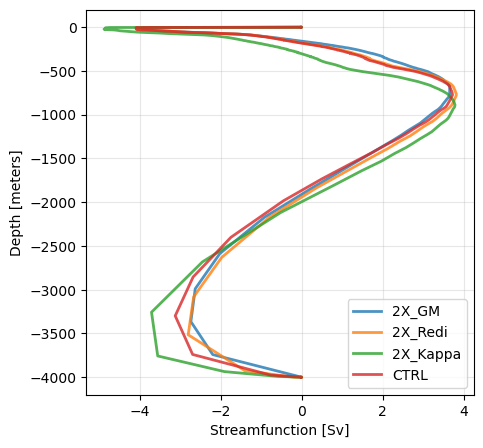

In [40]:
ds_experiments = [RunGM2x, RunRedi2x, Runkappa2x, Runctr]
experiment_labels = ["2X_GM", "2X_Redi", "2X_Kappa", "CTRL"]

fig, ax = plt.subplots(figsize = (5, 5))
ax.grid(alpha = 0.3)

for (i, ds_run) in enumerate(ds_experiments):
    idx_25S = find_nearest_idx(ds_run.Psi_xcoord[0, :], -25)
    z_prof = ds_run.Psi_ycoord[:, idx_25S]
    Psi_profile = ds_run.Psi[:, idx_25S]
    ax.plot(Psi_profile,
               z_prof, zorder = 10, linewidth = 2, alpha = 0.8, label = experiment_labels[i])
    # ax.scatter(Psi_profile,
    #            z_prof,
    #             label = experiment_labels[i], edgecolors = "k", 
    #             s = 40, zorder = 10, alpha = 0.95)

ax.legend()
ax.set_xlabel(r"Streamfunction [Sv]")
ax.set_ylabel(r"Depth [meters]")